In [1]:
import pandas as pd
import numpy as np
import spacy
import string
import re

from sklearn.model_selection import train_test_split

In [2]:
# Carrega a língua portuguesa no Spacy
# python -m spacy download pt
spacyPT = spacy.load('pt', disable = ["tagger", "parser", "ner"])
# stopwords = spacyPT.Defaults.stop_words
SEQUENCE_MAXLEN = 50

In [3]:
# Reading the Dataset
b2wCorpus = pd.read_csv("../data/B2W-Reviews01.csv", sep=';', usecols=["review_text", "overall_rating"])

In [4]:
def filtro(data, column, keep):
    '''
    Input:
        data - A pandas dataframe
        keep - A list with values to keep
        column - A string with the name of column to filter
    Output:
        clean - Dataset with only keep values in the column
    '''
    return data[data[column].isin(keep)]

In [5]:
def preprocess_sentence(sentence):
    '''
    Normalize preprocess a sequence of words
    in a sentence. 
    This function removes trailing and
    leading spaces; it lowercase each word;
    removes stop words; punctuations; and symbols;
    In the final step we lemmatize each word.
    Input:
        sentence - a string
        lowercase - boolean
    Output:
        a string of preprocessed text
    '''
    sentence = sentence.lower().strip()
    sentence = sentence.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    sentence = sentence.translate(str.maketrans('', '', string.digits))
    sentence = ' '.join([re.sub(r'(.)\1+', r'\1', word) for word in sentence.split() if len(word) < 15])
    sentence = spacyPT(sentence)
    lemmatized = list()
    for word in sentence:
        lemma = word.lemma_
        if lemma:
            lemmatized.append(lemma)
    return " ".join(lemmatized)

In [6]:
def partilha(data_in, data_out, val_size, test_size, seed=29):
    '''
    Input:
        data_in - Path of input csv - filename included
        data_out - Path of output csv
        val_size - proportion of validation set to splitting
        test_size - proportion of test set to splitting
        seed - int for reproducibility
    Output:
        train, test, val -  pandas dataframes - result of splitting the data
    '''
    assert test_size >= val_size
    # reading the dataset and suffling it
    usecols = ["review_text", "overall_rating"]
    dataset = pd.read_csv(data_in, sep=';', usecols=usecols)
    dataset = dataset[dataset.review_text.map(lambda sentence : len(sentence.split())) <= SEQUENCE_MAXLEN]
    dataset = filtro(dataset, 'overall_rating', [1,2,3,4,5])
    dataset = dataset.sample(frac=1, random_state=seed).reset_index(drop=True)
    dataset['review_text'] = dataset['review_text'].map(lambda sentence : preprocess_sentence(sentence))
    dataset['overall_rating'] = dataset['overall_rating'].map(lambda rate : rate - 1)
    
    # splitting the dataset - stratified splitting
    overall_size = (val_size + test_size)
    train, val = train_test_split(dataset, test_size=overall_size, stratify=dataset['overall_rating'], random_state=seed)
    test, val = train_test_split(val, test_size=val_size/overall_size, stratify=val['overall_rating'], random_state=seed)
    
    # reseting the index and saving the csv files on disk
    train.reset_index(drop=True, inplace=True)
    val.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    
    train.to_csv(data_out + "/" + "train.csv", sep=';', index=False)
    val.to_csv(data_out + "/" + "val.csv", sep=';', index=False)
    test.to_csv(data_out + "/" + "test.csv", sep=';', index=False)
    
    # printing the proportions of each set
    print('Train samples size: ', len(train))
    print('Val samples size: ', len(val))
    print('Test samples size: ', len(test))
    print()
    print('Train samples %: ', len(train)/(len(train)+len(val) + len(test)))
    print('Val samples %: ', len(val)/(len(train)+len(val) + len(test)))
    print('Test samples %: ', len(test)/(len(train)+len(val) + len(test)))
    print()
    print('Preprocessamento realizado com sucesso!')
    print('Arquivos csv  persistidos no diretório ' + data_out)
    
    return train, val, test

In [7]:
def create_subset_cbow():
    '''
    Cria um subconjunto do cbow de 50 dimensões do NILC
    200.000 palavras mais frequentes
    '''
    N = 200001
    with open("../data/cbow_s50.txt", "r") as file:
        head = [next(file) for x in range(N)]

    head[0] = str(N-1)+ " " + "50" + "\n"  # Conserta contagem de palavras
    with open("../data/word2vec_200k.txt", "w") as file:
        for line in head:
            file.write(line)

    print('Preprocessamento cbow 50 dim do Nilc realizado com sucesso')

In [8]:
# cria conjuntos de treino, validação e teste.
_, _, _ = partilha("../data/B2W-Reviews01.csv", "../data", .10, .25)

# Cria subconjunto do cbow de 50 dimensões do nilc
create_subset_cbow()

Train samples size:  78501
Val samples size:  12078
Test samples size:  30193

Train samples %:  0.6499933759480674
Val samples %:  0.10000662405193257
Test samples %:  0.25

Preprocessamento realizado com sucesso!
Arquivos csv  persistidos no diretório ../data
Preprocessamento cbow 50 dim do Nilc realizado com sucesso


<AxesSubplot:xlabel='overall_rating', ylabel='count'>

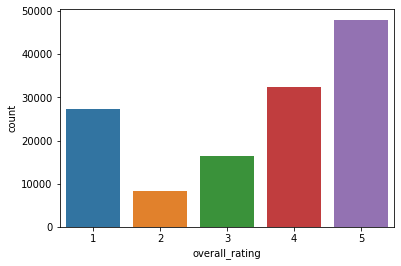

In [9]:
import seaborn as sns

sns.countplot(x='overall_rating', data=b2wCorpus)

In [10]:
sns.countplot(x='overall_rating', data=train)

NameError: name 'train' is not defined

In [ ]:
sns.countplot(x='overall_rating', data=val)

In [ ]:
sns.countplot(x='overall_rating', data=test)

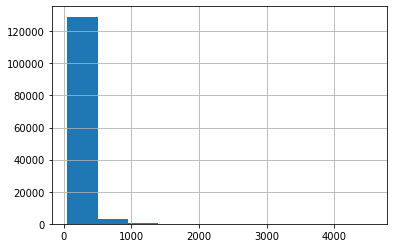

count    132373.000000
mean        141.778505
std         137.057280
min          50.000000
25%          68.000000
50%          97.000000
75%         160.000000
max        4548.000000
dtype: float64

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

reviews_len = [x for x in b2wCorpus.review_text.map(lambda x : len(x))]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

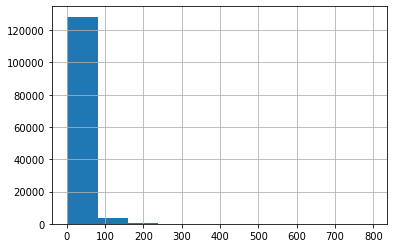

count    132373.000000
mean         23.877838
std          23.870872
min           1.000000
25%          11.000000
50%          16.000000
75%          27.000000
max         795.000000
dtype: float64

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

reviews_len = [x for x in b2wCorpus.review_text.map(lambda x : len(x.split()))]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [60]:
len(b2wCorpus[b2wCorpus.review_text.map(lambda x : len(x)) <= 200])

109163

In [70]:
len(b2wCorpus[b2wCorpus.review_text.map(lambda x : len(x)) <= 300])

121507

In [61]:
b2wCorpus = b2wCorpus[b2wCorpus.review_text.map(lambda x : len(x.split())) <= 200]

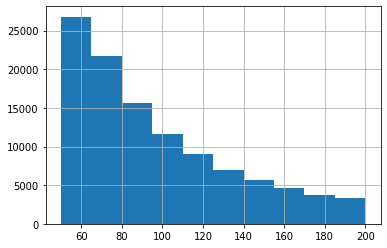

count    109163.000000
mean         95.885740
std          38.329537
min          50.000000
25%          65.000000
50%          85.000000
75%         119.000000
max         200.000000
dtype: float64

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

reviews_len = [x for x in b2wCorpus.review_text.map(lambda x : len(x))]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

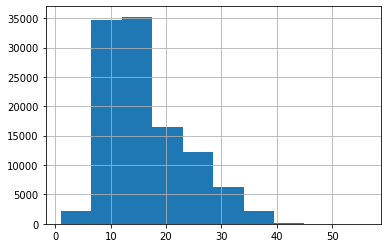

count    109163.000000
mean         15.949992
std           7.201497
min           1.000000
25%          10.000000
50%          14.000000
75%          20.000000
max          56.000000
dtype: float64

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

reviews_len = [x for x in b2wCorpus.review_text.map(lambda x : len(x.split()))]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [82]:
s = b2wCorpus[b2wCorpus.review_text.map(lambda x : len(x.split())) <= 50]

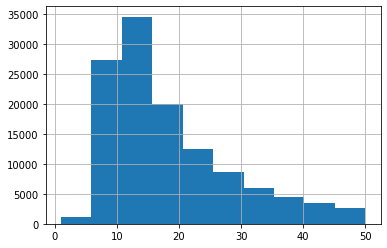

count    120772.000000
mean         18.283667
std          10.178751
min           1.000000
25%          11.000000
50%          15.000000
75%          23.000000
max          50.000000
dtype: float64

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

reviews_len = [x for x in s.review_text.map(lambda x : len(x.split()))]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [85]:
len(s)

120772

In [5]:
b2wCorpus.shape

(132373, 2)